In [2]:
from thesispy.experiments.wandb_client import *
from thesispy.experiments.validation import VALIDATION_NAMES, VALIDATION_ABBRVS
from thesispy.experiments.wandb_client import get_run_result
from thesispy.experiments.validation import *
from thesispy.plot_utils import *
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy.stats import ttest_ind


In [ ]:
ds = get_runs_as_dataset("synthetic_1_fair_comparison")
arrs = ds.aggregate_for_plot(["Optimizer", "MeshSize"])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(False)

for optimizer in ["GOMEA", "AdaptiveStochasticGradientDescent"]:
    for i, mesh_size in enumerate([(3, 3, 3), (4, 4, 4), (5, 5, 5)]):
        arr_avg, arr_median, arr_std = arrs[(optimizer, mesh_size)]
        xs = np.linspace(0, 1000, len(arr_avg))
        label = "RV-GOMEA" if optimizer == "GOMEA" else "ASGD"
        axes[i].plot(xs, arr_avg, label=label)
        axes[i].fill_between(xs, arr_avg - arr_std, arr_avg + arr_std, alpha=0.2)
        
        # formatting
        axes[i].set_yscale("log")
        axes[i].yaxis.set_major_formatter(formatter)
        axes[i].set_title(mesh_size_as_str(mesh_size), loc="center", fontsize=14)


axes[0].set_xlabel("Iteration", fontsize=12)
axes[0].set_ylabel("$MSD$", fontsize=12)
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc="lower center", prop={'size': 12})

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig("fair_comparison.pdf")

In [ ]:
df = ds.aggregate(["Optimizer", "MeshSize"], metrics=VALIDATION_NAMES, val=True)

In [ ]:
from tabulate import tabulate

rows = []

for i, metric in enumerate(VALIDATION_NAMES):
    row = []
    row.append(VALIDATION_ABBRVS[i])
    for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
        df_gomea = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "GOMEA")][metric]
        avg_gomea = df_gomea.mean()
        std_gomea = df_gomea.std()

        df_asgd = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "AdaptiveStochasticGradientDescent")][metric]
        avg_asgd = df_asgd.mean()
        std_asgd = df_asgd.std()
        
        gomea_better = avg_gomea < avg_asgd if metric != "dice_similarity" else avg_gomea > avg_asgd
        t_test = ttest_ind(df_gomea, df_asgd, equal_var=False)
        
        if t_test.pvalue >= 0.05:
            row.append(f"{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}")
            row.append(f"{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}")
            continue

        if gomea_better:
            row.append(f"\\textbf{{{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}}}")
            row.append(f"{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}")
        else:
            row.append(f"{avg_gomea:.2f} ± \\num{{{std_gomea:.1e}}}")
            row.append(f"\\textbf{{{avg_asgd:.2f} ± \\num{{{std_asgd:.1e}}}}}")

    rows.append(row)

print(tabulate(rows, headers=["RV-GOMEA", "ASGD"]*3, tablefmt="latex_raw"))

In [ ]:
ttest_results = []
df = ds.aggregate(["Optimizer", "MeshSize"], val=True)

for mesh_size in ["(3, 3, 3)", "(4, 4, 4)", "(5, 5, 5)"]:
    df_gomea = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "GOMEA")]["metric"].values
    df_asgd = df.loc[(df.MeshSize == mesh_size) & (df.Optimizer == "AdaptiveStochasticGradientDescent")]["metric"].values
    ttest_results.append(ttest_ind(df_gomea, df_asgd, equal_var=False))
    print(df_gomea.mean(), df_asgd.mean())
    print(df_gomea.std(), df_asgd.std())

print(ttest_results)

In [3]:
asgd_8 = get_run_result("synthetic_1_fair_comparison", "2oab4luv")
# gomea_8 = get_run_result("synthetic_1_fair_comparison", "2qurpss2")

In [ ]:
plot_run_result(gomea_8)
plt.savefig("nomr_gresult_gomea8.pdf")

2022-11-24 10:36:13,979 - Validation - INFO - Jacobian min,max: 0.12549756045875088, 7.285041841603664


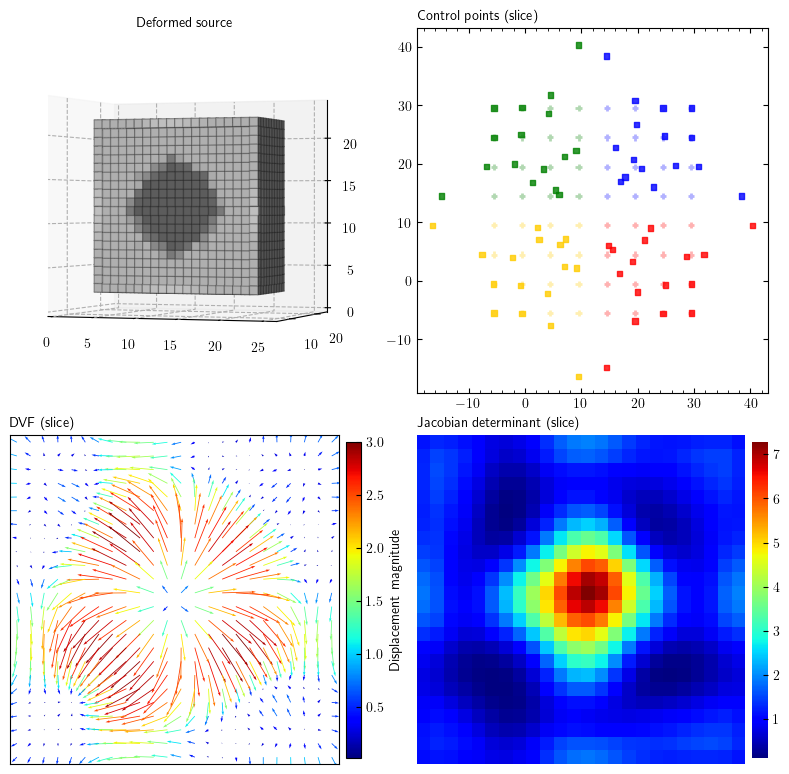

In [4]:
plot_run_result(asgd_8)
# plt.savefig("nomr_gresult_asgd8.pdf")